In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.sparse import issparse
from sklearn.feature_selection import RFE

In [4]:
# directory = "D:/LSE Lecture/ST443 - ML/ML Project"
# os.chdir(directory)

In [5]:
data = pd.read_csv("data2.csv.gz", compression='gzip')

## Task 2: Part 1
## EDA

In [6]:
print(data.shape)

(800, 100001)


#### There are 800 Compounds and 100000 binary features
##### (50000 real and 50000 random probes), first Column is the label n indicates whether the compound bound to a target site on thrombin(Thrombin is an enzyme in the blood that helps with clotting)

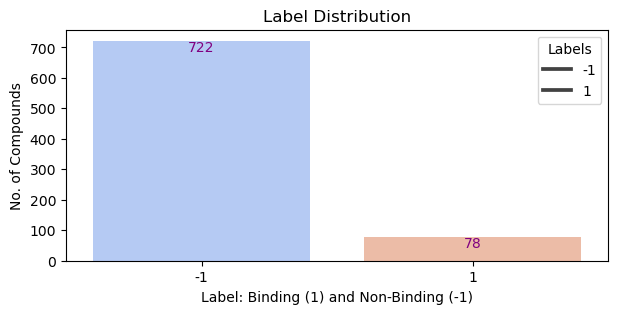

In [8]:
response_counts = data.iloc[:, 0].value_counts()
plt.figure(figsize=(7, 3))
ax = sns.barplot(
    x=response_counts.index, 
    y=response_counts.values, 
    palette="coolwarm"
)

plt.title("Label Distribution")
plt.xlabel("Label: Binding (1) and Non-Binding (-1)")
plt.ylabel("No. of Compounds")

for i, value in enumerate(response_counts.values):
    ax.text(i, value + 2, str(value), ha="center", va="top", fontsize=10, color="purple")

plt.legend(title="Labels", labels=response_counts.index.astype(str))
plt.show()

##### The dataset involves molecules, with binary features representing their 3D structures. Class +1 corresponds to molecules that bind to thrombin, and class -1 corresponds to those that do not. Only 9.26% of molecules belong to class +1.

In [9]:
#Missing Values
missing_values = data.isnull().sum().sum()
print("\nTotal Missing Values:", missing_values)


Total Missing Values: 0


In [10]:
features = data.iloc[:, 1:]
feature_summary = pd.DataFrame({ 'Mean': features.mean(), 'Standard Deev': features.std()})
print("\n Features Summary: \n",feature_summary.describe())


 Features Summary: 
                 Mean  Standard Deev
count  100000.000000  100000.000000
mean        0.009097       0.078676
std         0.011612       0.051968
min         0.000000       0.000000
25%         0.001250       0.035355
50%         0.005000       0.070578
75%         0.012500       0.111172
max         0.260000       0.438909


##### The summary again suggest that the data is highly sparse as even the most active feature has low intensity. the minimum mean zero suggest there are some features that are entirely inactive and are constant across all compounds

In [11]:
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]   # labels (-1 or 1)

In [12]:
active_features = (X!= 0).sum(axis=1)
active_features_binding = active_features[y == 1]
active_features_non_binding = active_features[y == -1]

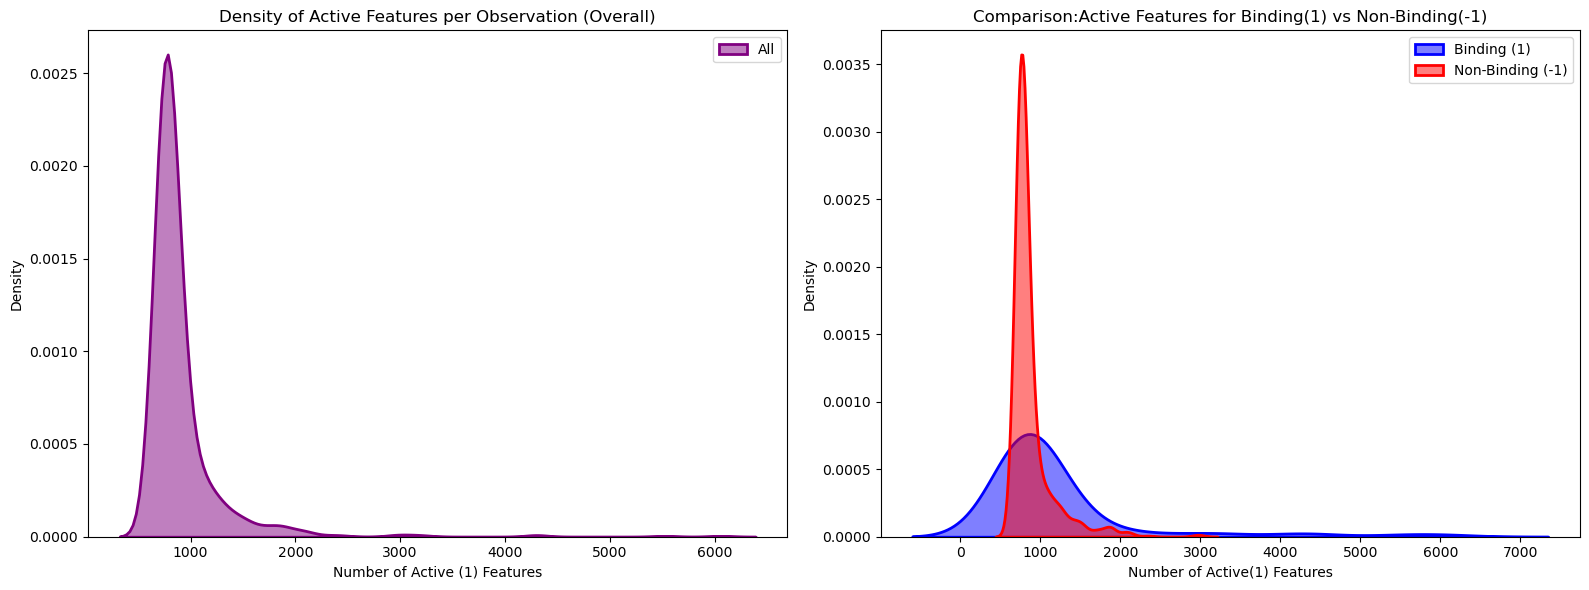

In [13]:
plt.figure(figsize=(16, 6))

#Overall distribution
plt.subplot(1, 2, 1)
sns.kdeplot(active_features, color="purple", label="All", linewidth=2, fill=True, alpha=0.5)
plt.title("Density of Active Features per Observation (Overall)")
plt.xlabel("Number of Active (1) Features")
plt.ylabel("Density")
plt.legend()

#  Comparison for Binding vs Non-Binding
plt.subplot(1, 2, 2)
sns.kdeplot(active_features_binding, color="blue", label="Binding (1)", linewidth=2, fill=True, alpha=0.5)
sns.kdeplot(active_features_non_binding, color="red", label="Non-Binding (-1)", linewidth=2, fill=True, alpha=0.5)
plt.title("Comparison:Active Features for Binding(1) vs Non-Binding(-1)")
plt.xlabel("Number of Active(1) Features")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

#### The left plot shows the overall distribution of active features per sample, peaking around ~1000 (suggesting most samples have approximately 1000 features or properties of a molecule present), indicating significant sparsity.The right plot compares active feature distributions for binding and non-binding classes, showing overlap but with slight differences, broader distribution of binding label shows that compounds which bind tend to have more active features on average. These graphs are highlighting the dataset's dimensionality reduction potential,and suggesting the use of techniques like L1 regularization or RFE .

# Task 2 Part 2

#### Three Type of Feature Selections in the course
#### 1) LASSO
#### 2) Gradient Boosting
#### 3) Random Forest

#### Preliminary filtering :Removing  the features that are nalways inactive or have 0 variance. This initial filtering decreases the dimensionality and removes uninformative features.

In [14]:
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]   # Target (-1 and 1)

#lets eliminate the constant features,that do not contribute to the variability in the dataset

variances = X.var()
X_filtered = X.loc[:, variances != 0]
# Get the number of features before and after removing zero variance features
original_num_features = X.shape[1]
filtered_num_features = X_filtered.shape[1]
num_removed_features = original_num_features - filtered_num_features
print(f"No of features removed: {num_removed_features}")

No of features removed: 11881


In [15]:
#(This makes the labels compatible with scikit-learn's models)
y = np.where(y == -1, 0, 1)

##### Split into train and test sets with stratify=y(Stratified sampling preserves the percentage of samples for each class), useful in imbalanced data sets to mitigate sampling bias when selecting your training and test data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.3, random_state=42, stratify=y)

In [17]:
#Standardize the features (mportant for PCA and LASSO)
# Convert to sparse matrix,Preserving Sparsity,only saving the non-zero values and their indices.
X_train_sparse = csr_matrix(X_train)
X_test_sparse = csr_matrix(X_test)
scaler = StandardScaler(with_mean=False)#preserves sparsity
X_train_scaled = scaler.fit_transform(X_train_sparse)
X_test_scaled= scaler.fit_transform(X_test_sparse)

In [18]:
results = []

## LASSO
#### We use LASSO for this task due to its ability to perform feature selection through L1 regularization, which reduces the number of features while preserving model accuracy. It automatically shrinks the coefficients of less important features to zero, making it ideal for high-dimensional datasets like DOROTHEA, where we need to minimize features without sacrificing predictive power.

In [19]:
# Define and fit the LASSO model
lasso = LogisticRegression(penalty='l1', solver='saga', C=0.01, max_iter=8000, class_weight='balanced', random_state=42)
lasso.fit(X_train_scaled, y_train)

# Check the number of iterations actually used
print(f"Number of iterations used during training: {lasso.n_iter_}")

selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Train a new Logistic Regression model on selected features
lr_lasso = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_lasso.fit(X_train_selected, y_train)

# Cross-validation to evaluate model performance
scores = cross_val_score(lasso, X_train_scaled, y_train, cv=3, scoring='accuracy')  # Cross-validation for LASSO
print("Lasso cross-validation scores:", scores)

# Make predictions and calculate Balanced Accuracy
y_pred = lr_lasso.predict(X_test_selected)
balanced_acc_lasso = balanced_accuracy_score(y_test, y_pred)

no_selected_features = X_train_selected.shape[1]
print(f"LASSO Results:\nBalanced Accuracy: {balanced_acc_lasso:.4f}\nNumber of Selected Features: {no_selected_features}")

Number of iterations used during training: [5146]
Lasso cross-validation scores: [0.90374332 0.93582888 0.93010753]
LASSO Results:
Balanced Accuracy: 0.8831
Number of Selected Features: 18


In [20]:
#Adding to Result
num_features_lasso = no_selected_features
results.append({'Method': 'LASSO','Balanced Accuracy': balanced_acc_lasso,'Number of Features': num_features_lasso})

In [21]:
print(results)

[{'Method': 'LASSO', 'Balanced Accuracy': 0.8830895612101783, 'Number of Features': 18}]


# Gradient Boosting

#### Given the large number of features, it is important to focus only on the most relevant ones, Gradient Boosting Classifier is a powerful non-linear model that can find subtle patterns in sparse data and rank the features by their importance.To determine the optimal number of features, we iteratively selected different subsets ( 50, 60, 70, 80, 90) and we selected the top 90 features based on their importance, which yielded the best balanced accuracy.

In [22]:
gb_model = GradientBoostingClassifier(random_state=50)
gb_model.fit(X_train_scaled, y_train)

feature_importances = gb_model.feature_importances_
important_indices = np.argsort(feature_importances)[-90:]  # Top 90 important features

X_train_gb = X_train_scaled[:, important_indices]
X_test_gb = X_test_scaled[:, important_indices]

lr_gb = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_gb.fit(X_train_gb, y_train)
y_pred_gb = lr_gb.predict(X_test_gb)
balanced_acc_gb = balanced_accuracy_score(y_test, y_pred_gb)
print(balanced_acc_gb)

0.8191745141254257


In [23]:
# adding to Result
results.append({'Method': 'Gradient Boosting','Balanced Accuracy': balanced_acc_gb,'Number of Features': 90})

# Random Forest
#### Random Forest is selected for its capacity to assess feature importance using an ensemble of decision trees. It effectively handles high-dimensional datasets and ranks features based on their contribution to model performance, helping identify the most relevant features for the task while maintaining stability. 

In [24]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# Feature selection using the importance of features
# Using SelectFromModel to select the most important features (based on the default threshold)
selector = SelectFromModel(rf_model, threshold='mean', max_features=50, importance_getter='auto') # adjust max_features
X_train_selected_rf= selector.transform(X_train_scaled)
X_test_selected_rf= selector.transform(X_test_scaled)

# Train a new Random Forest model on the selected features
rf_model_selected = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_selected.fit(X_train_selected_rf, y_train)

# Make predictions on the test set and calculate Balanced Accuracy
y_pred_rf = rf_model_selected.predict(X_test_selected_rf)
balanced_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)

# Output the results
num_selected_features = X_train_selected_rf.shape[1]  # Number of features selected after Random Forest selection
print(f"Random Forest Results:")
print(f"Balanced Accuracy: {balanced_acc_rf:.4f}")
print(f"Number of Selected Features: {num_selected_features}")

Random Forest Results:
Balanced Accuracy: 0.8053
Number of Selected Features: 50


In [25]:
# adding to Result

results.append({'Method': 'Random Forest','Balanced Accuracy': balanced_acc_rf,'Number of Features': 50})

In [26]:
results

[{'Method': 'LASSO',
  'Balanced Accuracy': 0.8830895612101783,
  'Number of Features': 18},
 {'Method': 'Gradient Boosting',
  'Balanced Accuracy': 0.8191745141254257,
  'Number of Features': 90},
 {'Method': 'Random Forest',
  'Balanced Accuracy': 0.8053496293327991,
  'Number of Features': 50}]

### Compare Results

In [27]:
results_df = pd.DataFrame(results)
print(results_df)

              Method  Balanced Accuracy  Number of Features
0              LASSO           0.883090                  18
1  Gradient Boosting           0.819175                  90
2      Random Forest           0.805350                  50


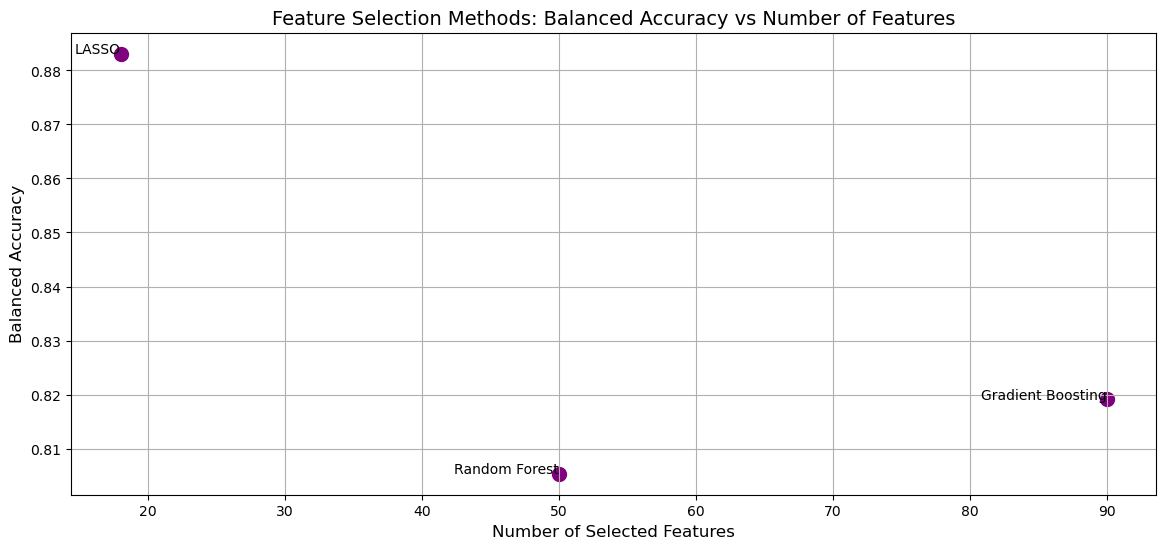

In [28]:
methods = results_df['Method']
num_features = results_df['Number of Features']
balanced_accuracies = results_df['Balanced Accuracy']

plt.figure(figsize=(14,6))
plt.scatter(num_features, balanced_accuracies, color='Purple', s=100, label='Balanced Accuracy')

for i, method in enumerate(methods):
    plt.text(num_features[i], balanced_accuracies[i], method, fontsize=10, ha='right')

plt.xlabel('Number of Selected Features', fontsize=12)
plt.ylabel('Balanced Accuracy', fontsize=12)
plt.title('Feature Selection Methods: Balanced Accuracy vs Number of Features', fontsize=14)
plt.grid(True)
plt.show()

# Task 2: Part 3

####  3 Type of feature selection out of the course
#### 1)  Mutual Information
#### 2)  Chisquare
#### 3)  RFE

In [29]:
results_2 = []

# Mutual Information

#### MI quantifies the amount of information that a feature X contributes to predicting the target variable Y and Features with higher mutual information values are considered more relevant because they provide more information about the target. it can identify both linear and non linera relationship. As the data here is highly imbalanced this method will be useful to helps identify features that are most informative even when one class is underrepresented.


In [30]:
# Calculate mutual information between each feature and the target variable
mutual_info = mutual_info_classif(X_train, y_train)

# Rank features based on their mutual information score
# Higher values indicate more informative features
sorted_idx = np.argsort(mutual_info)[::-1]  # Sort in descending order

# Select the top N features based on mutual information
top_n = 100  # Specify how many top features you want to select
selected_features_mi = sorted_idx[:top_n]  # Get indices of top N features

# If X_train is a DataFrame, use .iloc for selecting features by index
# Select the top features from the DataFrame using .iloc
X_train_selected_mi = X_train.iloc[:, selected_features_mi]
X_test_selected_mi = X_test.iloc[:, selected_features_mi]

# Train a Logistic Regression model using the selected features
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_selected_mi, y_train)

# Make predictions and calculate Balanced Accuracy
y_pred_mi = lr_model.predict(X_test_selected_mi)
balanced_acc_mi = balanced_accuracy_score(y_test, y_pred)

# Output the results
num_selected_features_mi = X_train_selected_mi.shape[1]
print(f"Balanced Accuracy with top {top_n} features selected by Mutual Information: {balanced_acc_mi:.4f}")
print(f"Number of Selected Features: {num_selected_features_mi}")

Balanced Accuracy with top 100 features selected by Mutual Information: 0.8831
Number of Selected Features: 100


In [31]:
#Adding Result
results_2.append({'Method': 'Mutual Information','Balanced Accuracy': balanced_acc_mi,'Number of Features': num_selected_features_mi})

# Chisquare


#### Chisquare is a straight forward and commonly used statiscal method. Features that have a higher chi-square statistic with respect to the class label are considered more informative and helps eliminating the features that are independent of the target.here The value of k = 100 was determined through iterative experimentation, selecting the number of features that yielded the highest balanced accuracy for the Logistic Regression model.

In [32]:
selector_chi2 = SelectKBest(score_func=chi2, k=100)# Select top 100 features
X_train_chi2 = selector_chi2.fit_transform(X_train_scaled, y_train)
X_test_chi2 = selector_chi2.transform(X_test_scaled)

lr_chi2 = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
lr_chi2.fit(X_train_chi2, y_train)
y_pred_chi2 = lr_chi2.predict(X_test_chi2)
balanced_acc_chi2 = balanced_accuracy_score(y_test, y_pred_chi2)

print(balanced_acc_chi2)

0.8715688238829894


In [33]:
#Result
results_2.append({ 'Method': 'Chi-Square', 'Balanced Accuracy': balanced_acc_chi2, 'Number of Features': X_train_chi2.shape[1]})

# RFE
#### Elimination (RFE) is efficient in selecting the most informative features. RFE works by removing less important features, improving model efficiency by focusing only on the most critical variables, which is essential for the high-dimensional DOROTHEA dataset. 

In [ ]:
# Create a Logistic Regression model as the base estimator
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Perform RFE to select features
num_features_to_select = 20  # Specify the number of features to select
rfe = RFE(estimator=lr, n_features_to_select=num_features_to_select, step=1)
rfe.fit(X_train_scaled, y_train)

# Get the selected features
selected_features_rfe = np.where(rfe.support_)[0]  # Indices of selected features
print(f"RFE Selected Features: {selected_features_rfe}")

# Transform the dataset to include only selected features
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

# Train a Logistic Regression model on the selected features
lr_rfe = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_rfe.fit(X_train_rfe, y_train)

# Make predictions and calculate Balanced Accuracy
y_pred_rfe = lr_rfe.predict(X_test_rfe)
balanced_acc_rfe = balanced_accuracy_score(y_test, y_pred_rfe)
print(f"Balanced Accuracy with RFE-selected features: {balanced_acc_rfe:.4f}")

# Cross-validation to evaluate the performance of the RFE-selected features
cv_scores_rfe = cross_val_score(lr, X_train_rfe, y_train, cv=3, scoring='balanced_accuracy')
print(f"Cross-validation scores with RFE-selected features: {cv_scores_rfe.mean():.4f}")

In [ ]:
# Plot feature importance based on RFE ranking
plt.figure(figsize=(10, 6))
plt.barh(range(len(selected_features_rfe)), rfe.estimator_.coef_[0])
plt.yticks(range(len(selected_features_rfe)), selected_features_rfe)
plt.xlabel("Coefficient Value (Feature Importance)")
plt.title("RFE Feature Importances (Logistic Regression)")
plt.show()

In [ ]:
# Adding result:
results_2.append({ 'Method': 'RFE', 'Balanced Accuracy': 0.8021, 'Number of Features': 20})

In [ ]:
results_2

# Comparison Graph

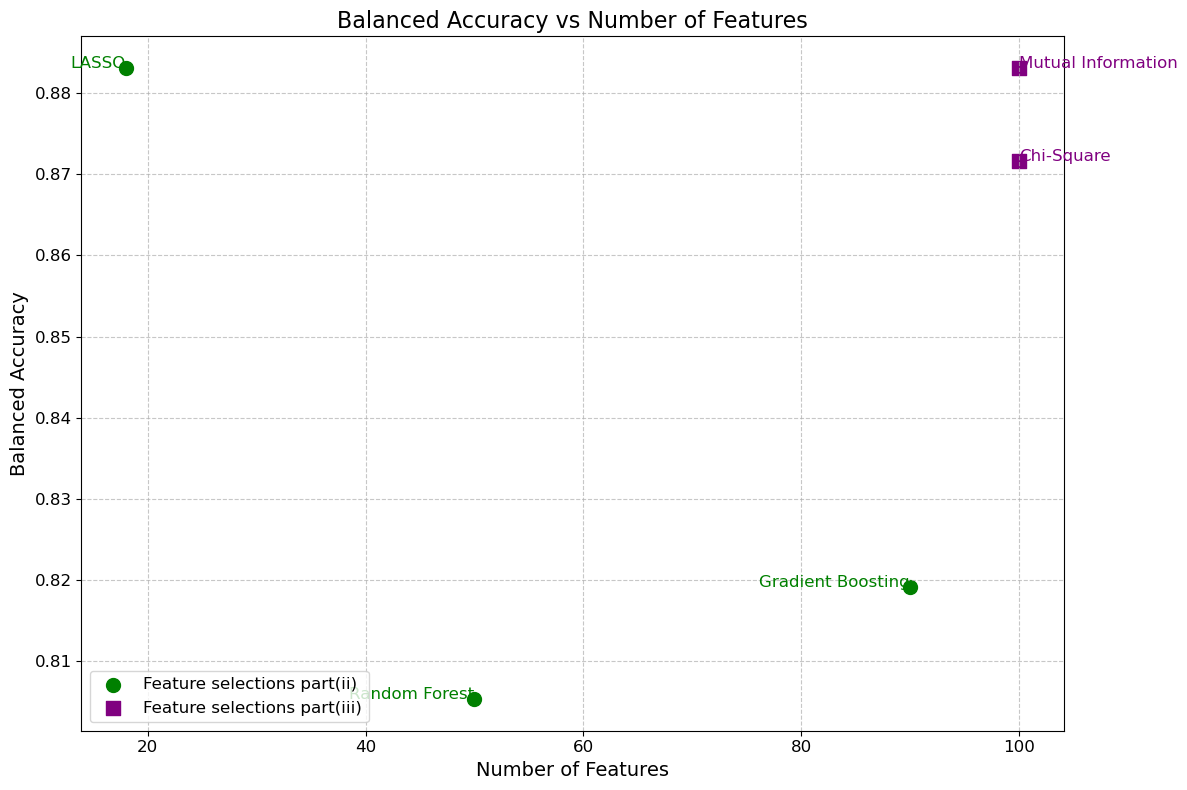

In [34]:
results_df = pd.DataFrame(results)# Results from LASSO, Gradient Boosting and Random Forest
results_2_df = pd.DataFrame(results_2)  # Mutual Information, Chi-Square and RFE

results_df
results_2_df

plt.figure(figsize=(12, 8))  

# Scatter plots for the two datasets
plt.scatter(results_df['Number of Features'], results_df['Balanced Accuracy'], 
            label='Feature selections part(ii)', marker='o', color='green', s=100)  
plt.scatter(results_2_df['Number of Features'], results_2_df['Balanced Accuracy'], 
            label='Feature selections part(iii)', marker='s', color='purple', s=100) 

for i in range(len(results_df)):
    plt.text(results_df['Number of Features'].iloc[i], results_df['Balanced Accuracy'].iloc[i],
             results_df['Method'].iloc[i], color='green', fontsize=12, ha='right') 

for i in range(len(results_2_df)):
    plt.text(results_2_df['Number of Features'].iloc[i], results_2_df['Balanced Accuracy'].iloc[i],
             results_2_df['Method'].iloc[i], color='purple', fontsize=12, ha='left') 


plt.title('Balanced Accuracy vs Number of Features', fontsize=16) 
plt.xlabel('Number of Features', fontsize=14)  
plt.ylabel('Balanced Accuracy', fontsize=14)  
plt.legend(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.tight_layout()  
plt.show()

Mutual Information and LASSO dominated in terms of balanced accuracy with number of features ranging from 18 to 100 out of the original 100,000 ,Indicating a strong noise filtering capabilities.Methods like RFE and Random Forest delivered moderate result, might have struggle when dealing with a high dimentionality feature space and low "signal-to-noise ratio".

